In [2]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device_u = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_v = torch.device('cuda:1' if torch.cuda.device_count() > 1 else device_u)
device_p = torch.device('cuda:2' if torch.cuda.device_count() > 2 else device_u)
device_T = torch.device('cuda:3' if torch.cuda.device_count() > 3 else device_u)

print(f"device_u: {device_u}")
print(f"device_v: {device_v}")
print(f"device_p: {device_p}")
print(f"device_T: {device_T}")

device_u: cuda:0
device_v: cuda:1
device_p: cuda:2
device_T: cuda:3


In [4]:
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers=4, neurons=50):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    

net_u = FCN(in_dim=3, out_dim=1).to(device_u)   # For u(x, y, t)
net_v = FCN(in_dim=3, out_dim=1).to(device_v)   # For v(x, y, t)
net_p = FCN(in_dim=3, out_dim=1).to(device_p)   # For p(x, y, t)
net_T = FCN(in_dim=3, out_dim=1).to(device_T)   # For T(x, y, t)

In [5]:
def generate_collocation_points(N):
    x = np.random.rand(N,1)
    y = np.random.rand(N,1)
    t = np.random.rand(N,1)

    X = np.hstack((x,y,t))

    return torch.tensor(X, dtype = torch.float32, requires_grad= True)

N_f = 10000
X_f = generate_collocation_points(N_f)

X_f_u = X_f.clone().detach().to(device_u).requires_grad_(True)
X_f_v = X_f.clone().detach().to(device_v).requires_grad_(True)
X_f_p = X_f.clone().detach().to(device_p).requires_grad_(True)
X_f_T = X_f.clone().detach().to(device_T).requires_grad_(True)


In [6]:
def generate_boundary_points(N):
    x = torch.rand(N,1)
    y = torch.rand(N,1)
    t = torch.rand(N,1)

    # Left / right boundary
    b_l = torch.cat([torch.zeros(N,1),y,t], dim = 1)
    b_r = torch.cat([torch.ones(N,1),y,t], dim = 1)

    # Bottom / top boundary
    b_b = torch.cat([x,torch.zeros(N,1),t], dim = 1)
    b_t = torch.cat([x,torch.ones(N,1),t], dim = 1)

    b = torch.cat([b_l, b_r, b_b, b_t], dim = 0)

    return b

N_b = 2000
X_b = generate_boundary_points(N_b)

X_b_u = X_b.clone().detach().to(device_u)
X_b_v = X_b.clone().detach().to(device_v)
X_b_T = X_b.clone().detach().to(device_T)


In [7]:
def generate_initial_points(N):
    x = torch.rand(N,1)
    y = torch.rand(N,1)
    t_0 = torch.zeros(N,1)

    initial = torch.cat([x,y,t_0], dim = 1)
    return initial

N_i = 2000
X_i = generate_initial_points(N_i)

X_i_u = X_i.clone().detach().to(device_u)
X_i_v = X_i.clone().detach().to(device_v)
X_i_T = X_i.clone().detach().to(device_T)

In [17]:
def compute_residual_u():
    # Evaluate u and its derivatives on device_u
    u = net_u(X_f_u)
    grads_u = autograd.grad(u, X_f_u, grad_outputs= torch.ones_like(u), create_graph= True)[0]

    u_x = grads_u[:,0:1]
    u_y = grads_u[:,1:2]
    u_t = grads_u[:,2:3]

    u_x_x = autograd.grad(u_x,X_f_u,grad_outputs= torch.ones_like(u_x), create_graph= True)[0][:,0:1]
    u_y_y = autograd.grad(u_y,X_f_u,grad_outputs= torch.ones_like(u_y), create_graph= True)[0][:,1:2]

    # Get v and p as constants on device_u
    v = net_v(X_f_v).detach().to(device_u)
    p = net_p(X_f_p)

    # Spatial derivatives of pressure
    p_x = autograd.grad(p,X_f_p, grad_outputs=torch.ones_like(p), create_graph= True, allow_unused= True)[0][:,0:1].to(device_u)

    nu = 0.01

    res_u = u_t + u * u_x + v * u_y + p_x - nu * (u_x_x + u_y_y)

    return res_u



In [9]:
def compute_residual_v():
    # Evaluate v and its derivatives on device_v
    v = net_v(X_f_v)
    grads_v = autograd.grad(v, X_f_v, grad_outputs= torch.ones_like(v), create_graph= True)[0]

    v_x = grads_v[:,0:1]
    v_y = grads_v[:,1:2]
    v_t = grads_v[:,2:3]

    v_x_x = autograd.grad(v_x,X_f_v,grad_outputs= torch.ones_like(v_x), create_graph= True)[0][:,0:1]
    v_y_y = autograd.grad(v_y,X_f_v,grad_outputs= torch.ones_like(v_y), create_graph= True)[0][:,1:2]

    # Get u and p as constants on device_v
    u = net_u(X_f_u).detach().to(device_v)
    p = net_p(X_f_p)

    # Pressure derivatives
    p_y = autograd.grad(p, X_f_p, grad_outputs=torch.ones_like(p), create_graph=True)[0][:, 1:2].to(device_v)

    nu = 0.01

    res_v = v_t + u * v_x + v * v_y + p_y - nu * (v_x_x + v_y_y)

    return res_v

In [18]:
def compute_residual_continuity():
    # Divergence of velocity field on GPU 0
    u = net_u(X_f_u)
    v = net_v(X_f_v)
    u_x = autograd.grad(u, X_f_u, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_y = autograd.grad(v, X_f_v, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1:2]
    res_c = u_x + v_y.to(device_u)
    return res_c

In [19]:
def compute_residual_T():
    # Evaluate T and its derivatives on device_T
    T = net_T(X_f_T)
    grads_T = autograd.grad(T, X_f_T, grad_outputs= torch.ones_like(T), create_graph=True)[0]

    T_x = grads_T[:,0:1]
    T_y = grads_T[:,1:2]
    T_t = grads_T[:,2:3]

    T_x_x = autograd.grad(T_x,X_f_T,grad_outputs= torch.ones_like(T_x), create_graph= True)[0][:,0:1]
    T_y_y = autograd.grad(T_y,X_f_T,grad_outputs= torch.ones_like(T_y), create_graph= True)[0][:,1:2]

    # Get u,v as constants on device_T
    u = net_u(X_f_u).detach().to(device_T)
    v = net_v(X_f_v).detach().to(device_T)

    alpha = 0.01  # thermal diffusivity
    # Energy equation residual
    res_T = T_t + u * T_x + v * T_y - alpha * (T_x_x + T_y_y)
    return res_T
    

In [12]:
def compute_bc_residuals():
    u_b = net_u(X_b_u)
    v_b = net_v(X_b_v)
    T_b = net_T(X_b_T)

    bc_u = torch.mean((u_b)**2)
    bc_v = torch.mean((v_b)**2)
    bc_T = torch.mean((T_b - 1.00)**2)

    return bc_u, bc_v, bc_T

In [13]:
def compute_ic_residuals():
    u_i = net_u(X_i_u)
    v_i = net_v(X_i_v)
    T_i = net_T(X_i_T)

    ic_u = torch.mean((u_i)**2)
    ic_v = torch.mean((v_i)**2)
    ic_T = torch.mean((T_i)**2)

    return ic_u, ic_v, ic_T

In [26]:
def compute_losses():
    # Compute individual residuals
    res_u = compute_residual_u()
    res_v = compute_residual_v()
    res_c = compute_residual_continuity()
    res_T = compute_residual_T()
    # Aggregate into per-network losses (MSE) and return
    loss_u = torch.mean(res_u**2) + torch.mean(res_c**2)
    loss_v = torch.mean(res_v**2)
    loss_T = torch.mean(res_T**2)

    # Boundary and initial condition losses
    bc_u, bc_v, bc_T = compute_bc_residuals()
    ic_u, ic_v, ic_T = compute_ic_residuals()

    loss_int = loss_u + loss_v.to(device_u) + loss_T.to(device_u)
    loss_bc = bc_u + bc_v.to(device_u) + bc_T.to(device_u)
    loss_ic = ic_u + ic_v.to(device_u) + ic_T.to(device_u)

    total_loss = (loss_int + loss_bc + loss_ic)

    return loss_u, loss_v, loss_T,bc_u, bc_v, bc_T, ic_u, ic_v, ic_T, total_loss

In [25]:
optimizer_u = torch.optim.Adam(net_u.parameters(), lr=1e-3)
optimizer_v = torch.optim.Adam(net_v.parameters(), lr=1e-3)
optimizer_p = torch.optim.Adam(net_p.parameters(), lr=1e-3)
optimizer_T = torch.optim.Adam(net_T.parameters(), lr=1e-3)

In [27]:
num_epochs = 5000

loss_u_list, loss_v_list, loss_T_list,bc_u_list, bc_v_list, bc_T_list, ic_u_list, ic_v_list, ic_T_list, total_loss_list = [], [],  [], [],[], [],  [], [], [], []

for epoch in range(num_epochs):
    optimizer_u.zero_grad()
    optimizer_v.zero_grad()
    optimizer_T.zero_grad()

    loss_u, loss_v, loss_T,bc_u, bc_v, bc_T, ic_u, ic_v, ic_T, total_loss = compute_losses()

    loss_u.backward(retain_graph=True)
    loss_v.backward(retain_graph=True)
    loss_T.backward(retain_graph=True)
    bc_u.backward(retain_graph=True)
    bc_v.backward(retain_graph=True)
    bc_T.backward(retain_graph=True)
    ic_u.backward(retain_graph=True)
    ic_v.backward(retain_graph=True)
    ic_T.backward()

    optimizer_u.step()
    optimizer_v.step()
    optimizer_T.step()

    loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item()); loss_T_list.append(loss_T.item()); 
    bc_u_list.append(bc_u.item()); bc_v_list.append(bc_v.item()); bc_T_list.append(bc_T.item()); 
    ic_u_list.append(ic_u.item()); ic_v_list.append(ic_v.item()); ic_T_list.append(ic_T.item()); 
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_T={loss_T.item():.3e}, total={total_loss.item():.3e}")

    

Epoch 0: loss_u=1.662e-03, loss_v=3.159e-04, loss_T=2.210e-03, total=8.433e-01
Epoch 500: loss_u=2.783e-05, loss_v=5.721e-06, loss_T=2.169e-02, total=2.058e-01
Epoch 1000: loss_u=2.473e-05, loss_v=5.475e-06, loss_T=1.112e-02, total=7.841e-02
Epoch 1500: loss_u=2.378e-05, loss_v=5.513e-06, loss_T=1.020e-02, total=6.207e-02
Epoch 2000: loss_u=2.651e-05, loss_v=5.577e-06, loss_T=1.057e-02, total=5.669e-02
Epoch 2500: loss_u=2.549e-05, loss_v=5.550e-06, loss_T=1.006e-02, total=5.401e-02
Epoch 3000: loss_u=2.539e-05, loss_v=5.732e-06, loss_T=8.316e-03, total=5.145e-02
Epoch 3500: loss_u=2.530e-05, loss_v=5.553e-06, loss_T=6.351e-03, total=4.893e-02
Epoch 4000: loss_u=2.603e-05, loss_v=5.566e-06, loss_T=5.257e-03, total=4.336e-02
Epoch 4500: loss_u=2.541e-05, loss_v=5.500e-06, loss_T=4.792e-03, total=3.989e-02


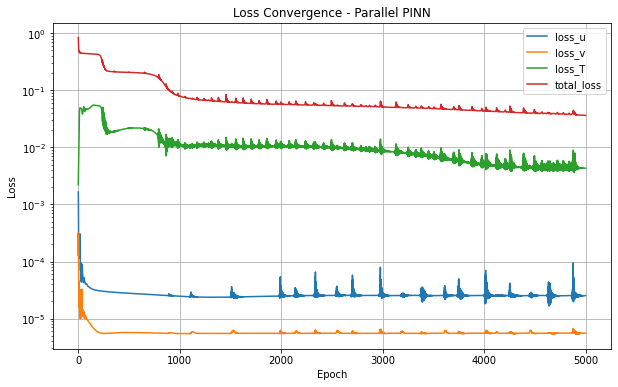

In [29]:
plt.figure(figsize=(10,6))
plt.plot(loss_u_list, label='loss_u')
plt.plot(loss_v_list, label='loss_v')
plt.plot(loss_T_list, label='loss_T')
plt.plot(total_loss_list, label='total_loss')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Convergence - Parallel PINN'); plt.legend(); plt.grid(True)
plt.show()